In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system','9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 16000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [6]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'])
    conv5 = conv2d(conv4, weights['wc5'], biases['bc5'])
    # Max Pooling (down-sampling)
    conv5 = maxpool2d(conv5, k=2)
    print(conv3.shape)
    print(conv4.shape)
    print(conv5.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv5, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)

    # Output, class prediction
    fc2 = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    print(fc2.shape)
    return fc2

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 128 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 128])),
    # 3x4 conv, 32 inputs, 128 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 128, 128])),
    # 3x4 conv, 64 inputs, 128 outputs
    'wc3': tf.Variable(tf.random_normal([3, 4, 128, 128])),
    # 3x4 conv, 64 inputs, 128 outputs
    'wc4': tf.Variable(tf.random_normal([3, 4, 128, 128])),
    # 3x4 conv, 32 inputs, 128 outputs
    'wc5': tf.Variable(tf.random_normal([3, 4, 128, 128])),
    # fully connected, 2*2*128 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*128, 1024])),
    # 1024 inputs, 14 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([128])),
    'bc2': tf.Variable(tf.random_normal([128])),
    'bc3': tf.Variable(tf.random_normal([128])),
    'bc4': tf.Variable(tf.random_normal([128])),
    'bc5': tf.Variable(tf.random_normal([128])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [7]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 128)
(?, 3, 4, 128)
(?, 3, 4, 128)
(?, 3, 4, 128)
(?, 2, 2, 128)
(?, 1024)
(?, 14)


# train and test

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 629209536.000000, Accuracy = 0.0170000009239
Performance on test set: Training epochs #1000, Batch Loss = 378613504.0, Accuracy = 0.0370000004768
Training epochs #20000: Batch Loss = 248831264.000000, Accuracy = 0.134000003338
Performance on test set: Training epochs #20000, Batch Loss = 65134944.0, Accuracy = 0.0140000013635
Training epochs #40000: Batch Loss = 58849480.000000, Accuracy = 0.516999959946
Performance on test set: Training epochs #40000, Batch Loss = 27325012.0, Accuracy = 0.805000066757
Training epochs #60000: Batch Loss = 41146352.000000, Accuracy = 0.75100004673
Performance on test set: Training epochs #60000, Batch Loss = 30837708.0, Accuracy = 0.805000066757
Training epochs #80000: Batch Loss = 30908824.000000, Accuracy = 0.758000016212
Performance on test set: Training epochs #80000, Batch Loss = 19222682.0, Accuracy = 0.805000066757
Training epochs #100000: Batch Loss = 151717184.000000, Accuracy = 0.129999995232
Performance on 

Training epochs #920000: Batch Loss = 7025857.000000, Accuracy = 0.794999957085
Performance on test set: Training epochs #920000, Batch Loss = 1587051.75, Accuracy = 0.955000042915
Training epochs #940000: Batch Loss = 4570552.000000, Accuracy = 0.901999950409
Performance on test set: Training epochs #940000, Batch Loss = 2733248.75, Accuracy = 0.955000042915
Training epochs #960000: Batch Loss = 3047761.500000, Accuracy = 0.935000002384
Performance on test set: Training epochs #960000, Batch Loss = 2991024.5, Accuracy = 0.955000042915
Training epochs #980000: Batch Loss = 33373256.000000, Accuracy = 0.352999985218
Performance on test set: Training epochs #980000, Batch Loss = 961988.1875, Accuracy = 0.961000025272
Training epochs #1000000: Batch Loss = 6514047.000000, Accuracy = 0.806000053883
Performance on test set: Training epochs #1000000, Batch Loss = 1369062.5, Accuracy = 0.961000025272
Training epochs #1020000: Batch Loss = 3987181.250000, Accuracy = 0.910000026226
Performance 

Training epochs #1820000: Batch Loss = 1744799.500000, Accuracy = 0.93599998951
Performance on test set: Training epochs #1820000, Batch Loss = 941977.75, Accuracy = 0.961000025272
Training epochs #1840000: Batch Loss = 892852.687500, Accuracy = 0.953000068665
Performance on test set: Training epochs #1840000, Batch Loss = 916332.6875, Accuracy = 0.961000025272
Training epochs #1860000: Batch Loss = 13632742.000000, Accuracy = 0.516000032425
Performance on test set: Training epochs #1860000, Batch Loss = 464365.5625, Accuracy = 0.983000040054
Training epochs #1880000: Batch Loss = 2271403.000000, Accuracy = 0.897000074387
Performance on test set: Training epochs #1880000, Batch Loss = 715021.125, Accuracy = 0.96899998188
Training epochs #1900000: Batch Loss = 1473736.625000, Accuracy = 0.933999955654
Performance on test set: Training epochs #1900000, Batch Loss = 824747.8125, Accuracy = 0.961000025272
Training epochs #1920000: Batch Loss = 1198612.250000, Accuracy = 0.940999984741
Perf

Training epochs #2720000: Batch Loss = 378117.781250, Accuracy = 0.977000057697
Performance on test set: Training epochs #2720000, Batch Loss = 233559.203125, Accuracy = 0.981999993324
Training epochs #2740000: Batch Loss = 7223002.000000, Accuracy = 0.600999951363
Performance on test set: Training epochs #2740000, Batch Loss = 286770.625, Accuracy = 0.990999996662
Training epochs #2760000: Batch Loss = 1037616.125000, Accuracy = 0.930999994278
Performance on test set: Training epochs #2760000, Batch Loss = 303829.46875, Accuracy = 0.969000041485
Training epochs #2780000: Batch Loss = 663715.500000, Accuracy = 0.959000051022
Performance on test set: Training epochs #2780000, Batch Loss = 280426.53125, Accuracy = 0.967999994755
Training epochs #2800000: Batch Loss = 512127.031250, Accuracy = 0.974000036716
Performance on test set: Training epochs #2800000, Batch Loss = 212149.59375, Accuracy = 0.982000112534
Training epochs #2820000: Batch Loss = 6509723.500000, Accuracy = 0.63399994373

Training epochs #3620000: Batch Loss = 4236738.500000, Accuracy = 0.704999983311
Performance on test set: Training epochs #3620000, Batch Loss = 175879.4375, Accuracy = 0.991000056267
Training epochs #3640000: Batch Loss = 316221.218750, Accuracy = 0.969000101089
Performance on test set: Training epochs #3640000, Batch Loss = 88729.0234375, Accuracy = 0.990000009537
Training epochs #3660000: Batch Loss = 294122.031250, Accuracy = 0.977999985218
Performance on test set: Training epochs #3660000, Batch Loss = 72085.78125, Accuracy = 0.982000112534
Training epochs #3680000: Batch Loss = 123794.250000, Accuracy = 0.986999988556
Performance on test set: Training epochs #3680000, Batch Loss = 48129.5546875, Accuracy = 0.983000040054
Training epochs #3700000: Batch Loss = 4033136.500000, Accuracy = 0.709999918938
Performance on test set: Training epochs #3700000, Batch Loss = 183059.65625, Accuracy = 0.991000056267
Training epochs #3720000: Batch Loss = 356007.562500, Accuracy = 0.96700000762

Training epochs #4520000: Batch Loss = 121685.296875, Accuracy = 0.98199993372
Performance on test set: Training epochs #4520000, Batch Loss = 10072.3085938, Accuracy = 0.994000077248
Training epochs #4540000: Batch Loss = 241320.250000, Accuracy = 0.981999993324
Performance on test set: Training epochs #4540000, Batch Loss = 2814.47412109, Accuracy = 0.999000072479
Training epochs #4560000: Batch Loss = 21978.812500, Accuracy = 0.995000064373
Performance on test set: Training epochs #4560000, Batch Loss = 37.0360031128, Accuracy = 0.999000072479
Training epochs #4580000: Batch Loss = 2746792.000000, Accuracy = 0.759000062943
Performance on test set: Training epochs #4580000, Batch Loss = 132550.140625, Accuracy = 0.990999996662
Training epochs #4600000: Batch Loss = 183983.500000, Accuracy = 0.976999998093
Performance on test set: Training epochs #4600000, Batch Loss = 17650.4511719, Accuracy = 0.991000056267
Training epochs #4620000: Batch Loss = 284881.468750, Accuracy = 0.971999943

Training epochs #5440000: Batch Loss = 20299.722656, Accuracy = 0.997000038624
Performance on test set: Training epochs #5440000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #5460000: Batch Loss = 1688774.750000, Accuracy = 0.769999980927
Performance on test set: Training epochs #5460000, Batch Loss = 78072.9140625, Accuracy = 0.991000056267
Training epochs #5480000: Batch Loss = 90092.500000, Accuracy = 0.98400002718
Performance on test set: Training epochs #5480000, Batch Loss = 1600.92602539, Accuracy = 0.994000077248
Training epochs #5500000: Batch Loss = 152129.265625, Accuracy = 0.981999993324
Performance on test set: Training epochs #5500000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #5520000: Batch Loss = 27823.087891, Accuracy = 0.992000102997
Performance on test set: Training epochs #5520000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #5540000: Batch Loss = 1842521.875000, Accuracy = 0.778999984264
Performance on test set: Train

Training epochs #6380000: Batch Loss = 109616.039062, Accuracy = 0.986000061035
Performance on test set: Training epochs #6380000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6400000: Batch Loss = 11641.644531, Accuracy = 0.996999979019
Performance on test set: Training epochs #6400000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6420000: Batch Loss = 978913.000000, Accuracy = 0.829000115395
Performance on test set: Training epochs #6420000, Batch Loss = 33171.4492188, Accuracy = 0.991000056267
Training epochs #6440000: Batch Loss = 49842.054688, Accuracy = 0.992000043392
Performance on test set: Training epochs #6440000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6460000: Batch Loss = 81429.414062, Accuracy = 0.989000022411
Performance on test set: Training epochs #6460000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #6480000: Batch Loss = 18996.363281, Accuracy = 0.992000102997
Performance on test set: Training epochs #6

Training epochs #7320000: Batch Loss = 25958.113281, Accuracy = 0.991000115871
Performance on test set: Training epochs #7320000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7340000: Batch Loss = 43546.632812, Accuracy = 0.991000056267
Performance on test set: Training epochs #7340000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7360000: Batch Loss = 3859.048340, Accuracy = 0.997000038624
Performance on test set: Training epochs #7360000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7380000: Batch Loss = 588744.687500, Accuracy = 0.888999998569
Performance on test set: Training epochs #7380000, Batch Loss = 14289.3134766, Accuracy = 0.996999979019
Training epochs #7400000: Batch Loss = 11781.274414, Accuracy = 0.995999991894
Performance on test set: Training epochs #7400000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #7420000: Batch Loss = 38726.394531, Accuracy = 0.992999911308
Performance on test set: Training epochs #742

Training epochs #8260000: Batch Loss = 454777.093750, Accuracy = 0.879000008106
Performance on test set: Training epochs #8260000, Batch Loss = 11782.7792969, Accuracy = 0.996999979019
Training epochs #8280000: Batch Loss = 12632.619141, Accuracy = 0.989999890327
Performance on test set: Training epochs #8280000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8300000: Batch Loss = 12165.769531, Accuracy = 0.996000051498
Performance on test set: Training epochs #8300000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8320000: Batch Loss = 254.527008, Accuracy = 0.999000072479
Performance on test set: Training epochs #8320000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #8340000: Batch Loss = 270102.437500, Accuracy = 0.924000024796
Performance on test set: Training epochs #8340000, Batch Loss = 3412.78662109, Accuracy = 0.997000098228
Training epochs #8360000: Batch Loss = 12143.681641, Accuracy = 0.989999949932
Performance on test set: Training 

Training epochs #9220000: Batch Loss = 241700.453125, Accuracy = 0.918000042439
Performance on test set: Training epochs #9220000, Batch Loss = 1611.9810791, Accuracy = 0.997000098228
Training epochs #9240000: Batch Loss = 7023.945312, Accuracy = 0.996000051498
Performance on test set: Training epochs #9240000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9260000: Batch Loss = 2532.080811, Accuracy = 0.997000098228
Performance on test set: Training epochs #9260000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9280000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #9280000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #9300000: Batch Loss = 191248.312500, Accuracy = 0.921000003815
Performance on test set: Training epochs #9300000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #9320000: Batch Loss = 10203.595703, Accuracy = 0.994000017643
Performance on test set: Training epochs #9320000, Batch Loss

Training epochs #10180000: Batch Loss = 187627.906250, Accuracy = 0.90700006485
Performance on test set: Training epochs #10180000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10200000: Batch Loss = 1209.995605, Accuracy = 0.997000038624
Performance on test set: Training epochs #10200000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10220000: Batch Loss = 11250.183594, Accuracy = 0.993000030518
Performance on test set: Training epochs #10220000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10240000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #10240000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10260000: Batch Loss = 157445.109375, Accuracy = 0.917999982834
Performance on test set: Training epochs #10260000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #10280000: Batch Loss = 3635.148193, Accuracy = 0.997000098228
Performance on test set: Training epochs #10280000,

Training epochs #11140000: Batch Loss = 136450.421875, Accuracy = 0.925999939442
Performance on test set: Training epochs #11140000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #11160000: Batch Loss = 2580.653320, Accuracy = 0.997000098228
Performance on test set: Training epochs #11160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11180000: Batch Loss = 1997.863159, Accuracy = 0.998000025749
Performance on test set: Training epochs #11180000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11200000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #11200000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11220000: Batch Loss = 77189.929688, Accuracy = 0.96899998188
Performance on test set: Training epochs #11220000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11240000: Batch Loss = 3907.177734, Accuracy = 0.996000051498
Performance on test set: Training epochs #11240000, Batch Loss 

Training epochs #12100000: Batch Loss = 64150.921875, Accuracy = 0.97000002861
Performance on test set: Training epochs #12100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12120000: Batch Loss = 812.581543, Accuracy = 0.998000025749
Performance on test set: Training epochs #12120000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #12140000: Batch Loss = 1080.232788, Accuracy = 0.999000072479
Performance on test set: Training epochs #12140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12160000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #12160000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12180000: Batch Loss = 76776.179688, Accuracy = 0.951000094414
Performance on test set: Training epochs #12180000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #12200000: Batch Loss = 3611.155029, Accuracy = 0.998000025749
Performance on test set: Training epochs #12200000, Batch Loss = 0.0, Accur

Training epochs #13060000: Batch Loss = 72644.734375, Accuracy = 0.958000063896
Performance on test set: Training epochs #13060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13080000: Batch Loss = 8236.917969, Accuracy = 0.991999983788
Performance on test set: Training epochs #13080000, Batch Loss = 758.093811035, Accuracy = 0.999000072479
Training epochs #13100000: Batch Loss = 2401.428223, Accuracy = 0.999000072479
Performance on test set: Training epochs #13100000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13120000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #13120000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13140000: Batch Loss = 62793.257812, Accuracy = 0.959999978542
Performance on test set: Training epochs #13140000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13160000: Batch Loss = 55068.960938, Accuracy = 0.984000086784
Performance on test set: Training epochs 

Training epochs #13980000: Batch Loss = 2730.651123, Accuracy = 0.995000123978
Performance on test set: Training epochs #13980000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #14000000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #14000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14020000: Batch Loss = 48998.687500, Accuracy = 0.949000060558
Performance on test set: Training epochs #14020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14040000: Batch Loss = 632.493286, Accuracy = 0.997000098228
Performance on test set: Training epochs #14040000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14060000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #14060000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14080000: Batch Loss = 197.489761, Accuracy = 0.999000072479
Performance on test set: Training epochs #14080000, Batch Loss = 0.0, 

Training epochs #14940000: Batch Loss = 219.651260, Accuracy = 0.999000072479
Performance on test set: Training epochs #14940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14960000: Batch Loss = 754.054199, Accuracy = 0.999000072479
Performance on test set: Training epochs #14960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14980000: Batch Loss = 10857.226562, Accuracy = 0.982000112534
Performance on test set: Training epochs #14980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15000000: Batch Loss = 318.162262, Accuracy = 0.997000038624
Performance on test set: Training epochs #15000000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15020000: Batch Loss = 2797.670654, Accuracy = 0.999000072479
Performance on test set: Training epochs #15020000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15040000: Batch Loss = 0.000000, Accuracy = 1.0
Performance on test set: Training epochs #15040000, Batch Loss = 0.

Training epochs #15900000: Batch Loss = 364.740753, Accuracy = 0.998000025749
Performance on test set: Training epochs #15900000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15920000: Batch Loss = 0.000000, Accuracy = 1.00000011921
Performance on test set: Training epochs #15920000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #15940000: Batch Loss = 19844.769531, Accuracy = 0.967000067234
Performance on test set: Training epochs #15940000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15960000: Batch Loss = 656.348511, Accuracy = 0.998000144958
Performance on test set: Training epochs #15960000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15980000: Batch Loss = 368.468628, Accuracy = 0.998000025749
Performance on test set: Training epochs #15980000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #16000000: Batch Loss = 200.018890, Accuracy = 0.999000072479
Performance on test set: Training epochs #16000000, Batch Loss = 0.0

# performance visualization

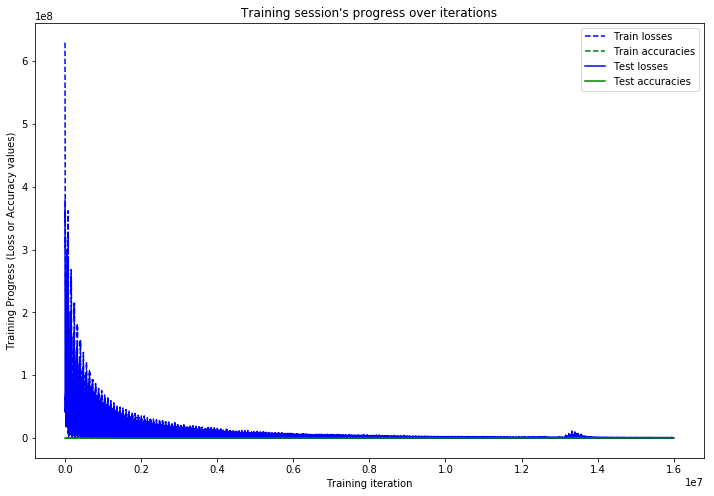

In [9]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 97.4709560878%
Recall: 97.56%
f1_score: 97.503621236%

Confusion Matrix:
[[    0    18     0     0     0     0     0     0     0     0     0     0
      0]
 [    5   781     0     0    28    38     9    23     0     0     0    27
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0    38     0     0  2795    10     2    43     0     0     0     3
      0]
 [    0    54     0     0     2   290     1     0     0     0     0     1
      0]
 [    0     7     0     0     0     0 14486     0     0     0     0     2
      0]
 [    0    43     0     0    55    24     0   407     0     0     0     6
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     2     0     2
      0]
 [    0     0     0     0     0     0     0    

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


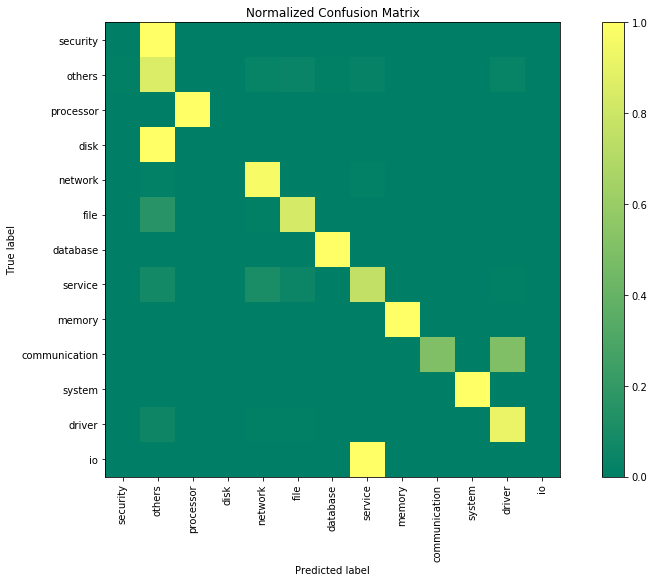

In [10]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)